# Generación datos faltantes

## Inicio

Este notebook sirve para generar datos faltantes en un dataset completo

In [30]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random

Establecemos el porcentaje de nulos que deseamos generar

In [31]:
porcentaje = 0.2

In [ ]:
warnings.filterwarnings('ignore', category=SyntaxWarning)  # Porque el \d de \data y \daily lo toma como un valor especial
dataframe = pd.read_csv("..\data\monthly-sunspots.csv", header=0, index_col=0, parse_dates=True)
series = dataframe.squeeze('columns')
series.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Lo pasamos a float

In [33]:
series = series.astype(float)
series.dtypes

dtype('float64')

In [34]:
len(series)

3650

Dibujamos

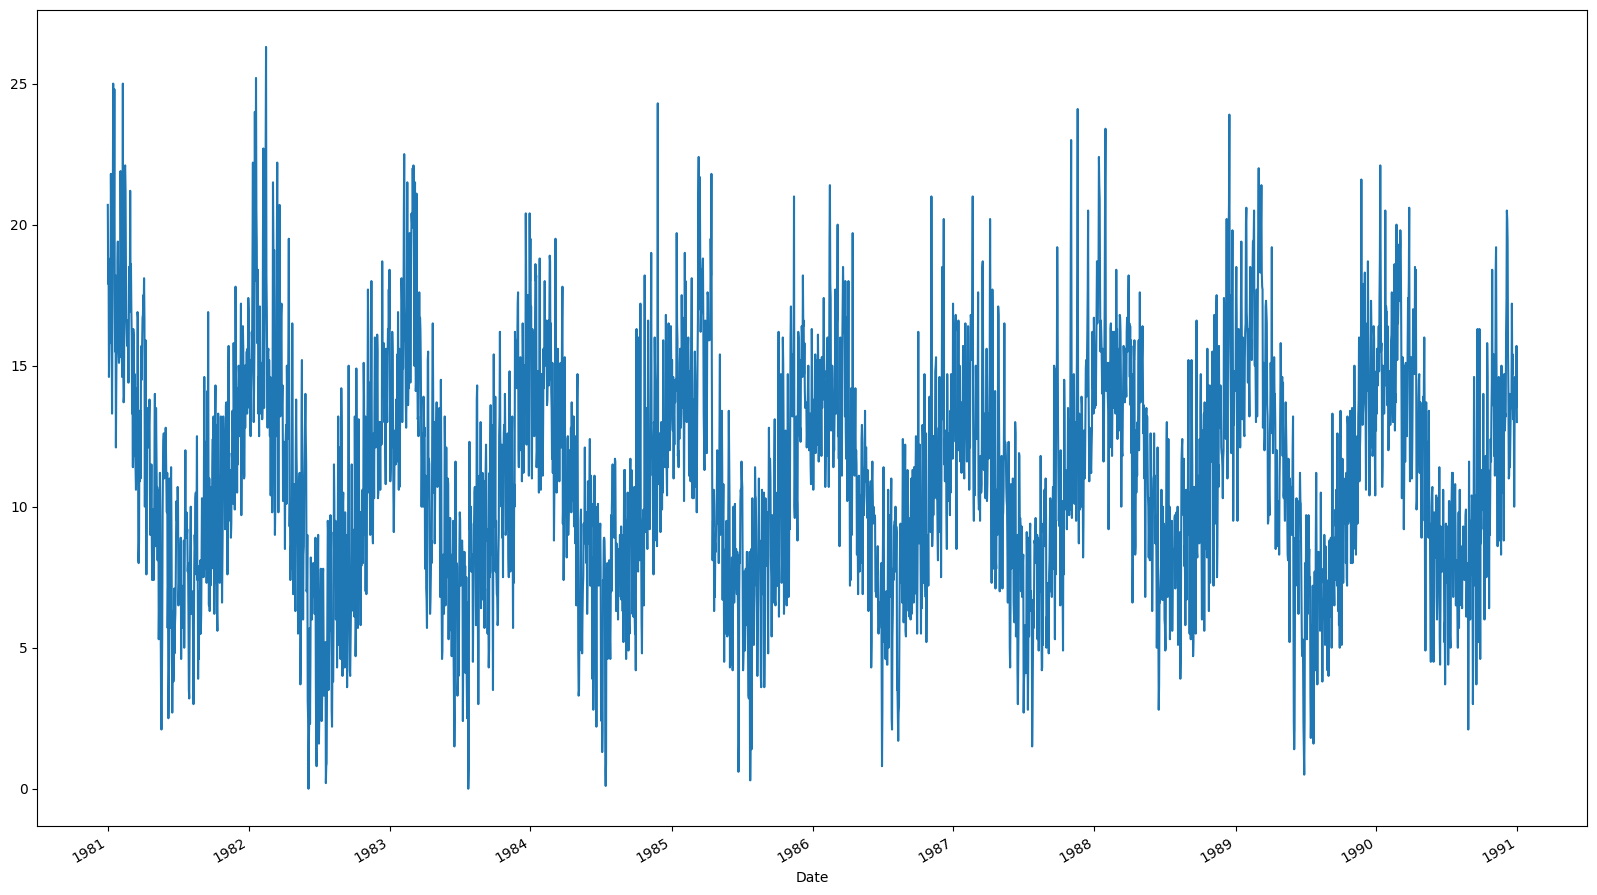

In [35]:
series.plot(figsize=(20,12))
plt.show()

Comprobamos que no haya nulos

c:\Users\alaba\Importante\4º Carrera\TFG\WorkspaceTFG\env\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


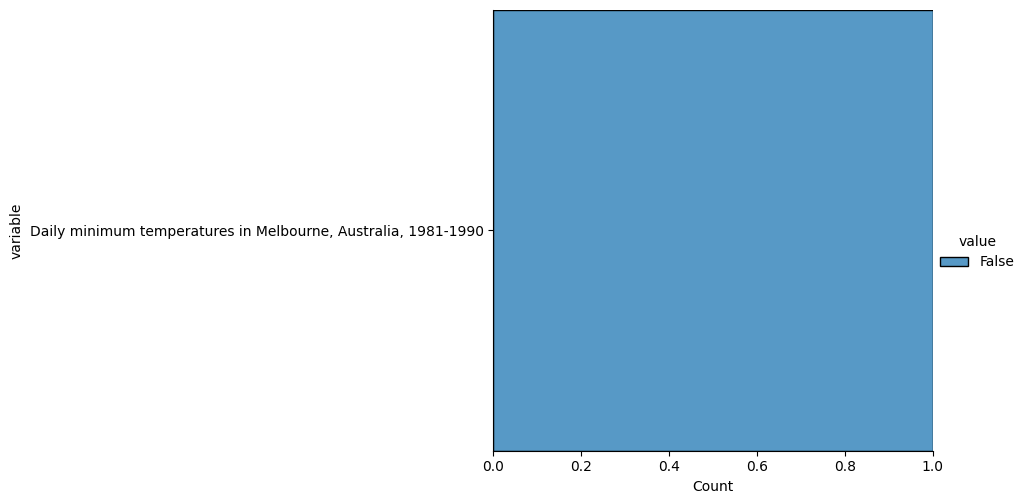

In [36]:
dataframe.isnull().melt().pipe(lambda df: (sns.displot(data=df, y='variable', hue='value', multiple='fill')))

Comprobamos si están todos los días

In [ ]:
series = series.resample('ME').mean() # Para los meses
#series = series.resample('D').mean() # Para los dias
#series = series.resample('h').mean() #Para las horas
series[series.isna()]

Date
1984-12-31   NaN
1988-12-31   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Solo hay 2, los podemos imputar a mano ya que son pocos, conocemos donde estan y sus valores cercanos, y no tendrán casi ningún impacto en el resultado del dataset

In [ ]:
#series['1984-12-31'] = (series['1984-12-30'] + series['1985-01-01'])/2
#print(series['1984-12-31'])

#series['1988-12-31'] = (series['1988-12-30'] + series['1989-01-01'])/2
#print(series['1988-12-31'])

14.85
14.2


## Funciones auxiliares

### Graficar con nulos

In [39]:
def dibuja_datos(serie):
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(20, 12))

    # Dibujar la serie temporal
    ax.plot(serie.index, serie.values, color='blue')

    # Dibujar líneas verticales rojas para los valores nulos
    null_dates = serie[serie.isna()].index
    for date in null_dates:
        ax.axvline(x=date, color='red', linestyle='-', alpha=0.5)

    # Configurar el gráfico
    ax.set_title('Serie Temporal con Marcadores de Valores Nulos')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.grid(True)

    # Rotar las etiquetas del eje x para mejor legibilidad
    plt.xticks(rotation=45)

    # Ajustar el diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()


### Eliminar datos consecutivos

In [40]:
def eliminar_consecutivos(serie, indices, n_eliminar, min, max):
    while len(serie[serie.isna()]) < n_eliminar:
        i = random.choice(indices)
        diferencia = n_eliminar - len(serie[serie.isna()])
        if diferencia < max:
            numero_aleatorio = random.randint(0, diferencia)
        else:
            numero_aleatorio = random.randint(min, max)
        inicio = serie.index.get_loc(i)
        final = serie.index.get_loc(i)+numero_aleatorio
        if final >= len(serie):
            inicio -= numero_aleatorio
            final -= numero_aleatorio
        serie.iloc[inicio:final] = np.nan
    return serie

### Eliminar por zona

In [41]:
def eliminar_zona(serie, indices, n_eliminar, min, max):
    while len(serie[serie.isna()]) < n_eliminar:
        i = random.choice(indices)
        diferencia = n_eliminar - len(serie[serie.isna()])
        if diferencia < max:
            numero_aleatorio = random.randint(0, diferencia)
        else:
            numero_aleatorio = random.randint(min, max)
        inicio = serie.index.get_loc(i)
        final = serie.index.get_loc(i)+numero_aleatorio
        if final >= len(serie):
            inicio -= numero_aleatorio
            final -= numero_aleatorio
        j = inicio
        while j < final:
            ran = random.choice([0,1,2])
            if ran == 0:
                serie.iloc[j] = np.nan
            j +=1
    return serie

## Insertar nulos en puntos aleatorios

Seguramente no se llegue a utilizar tal cual

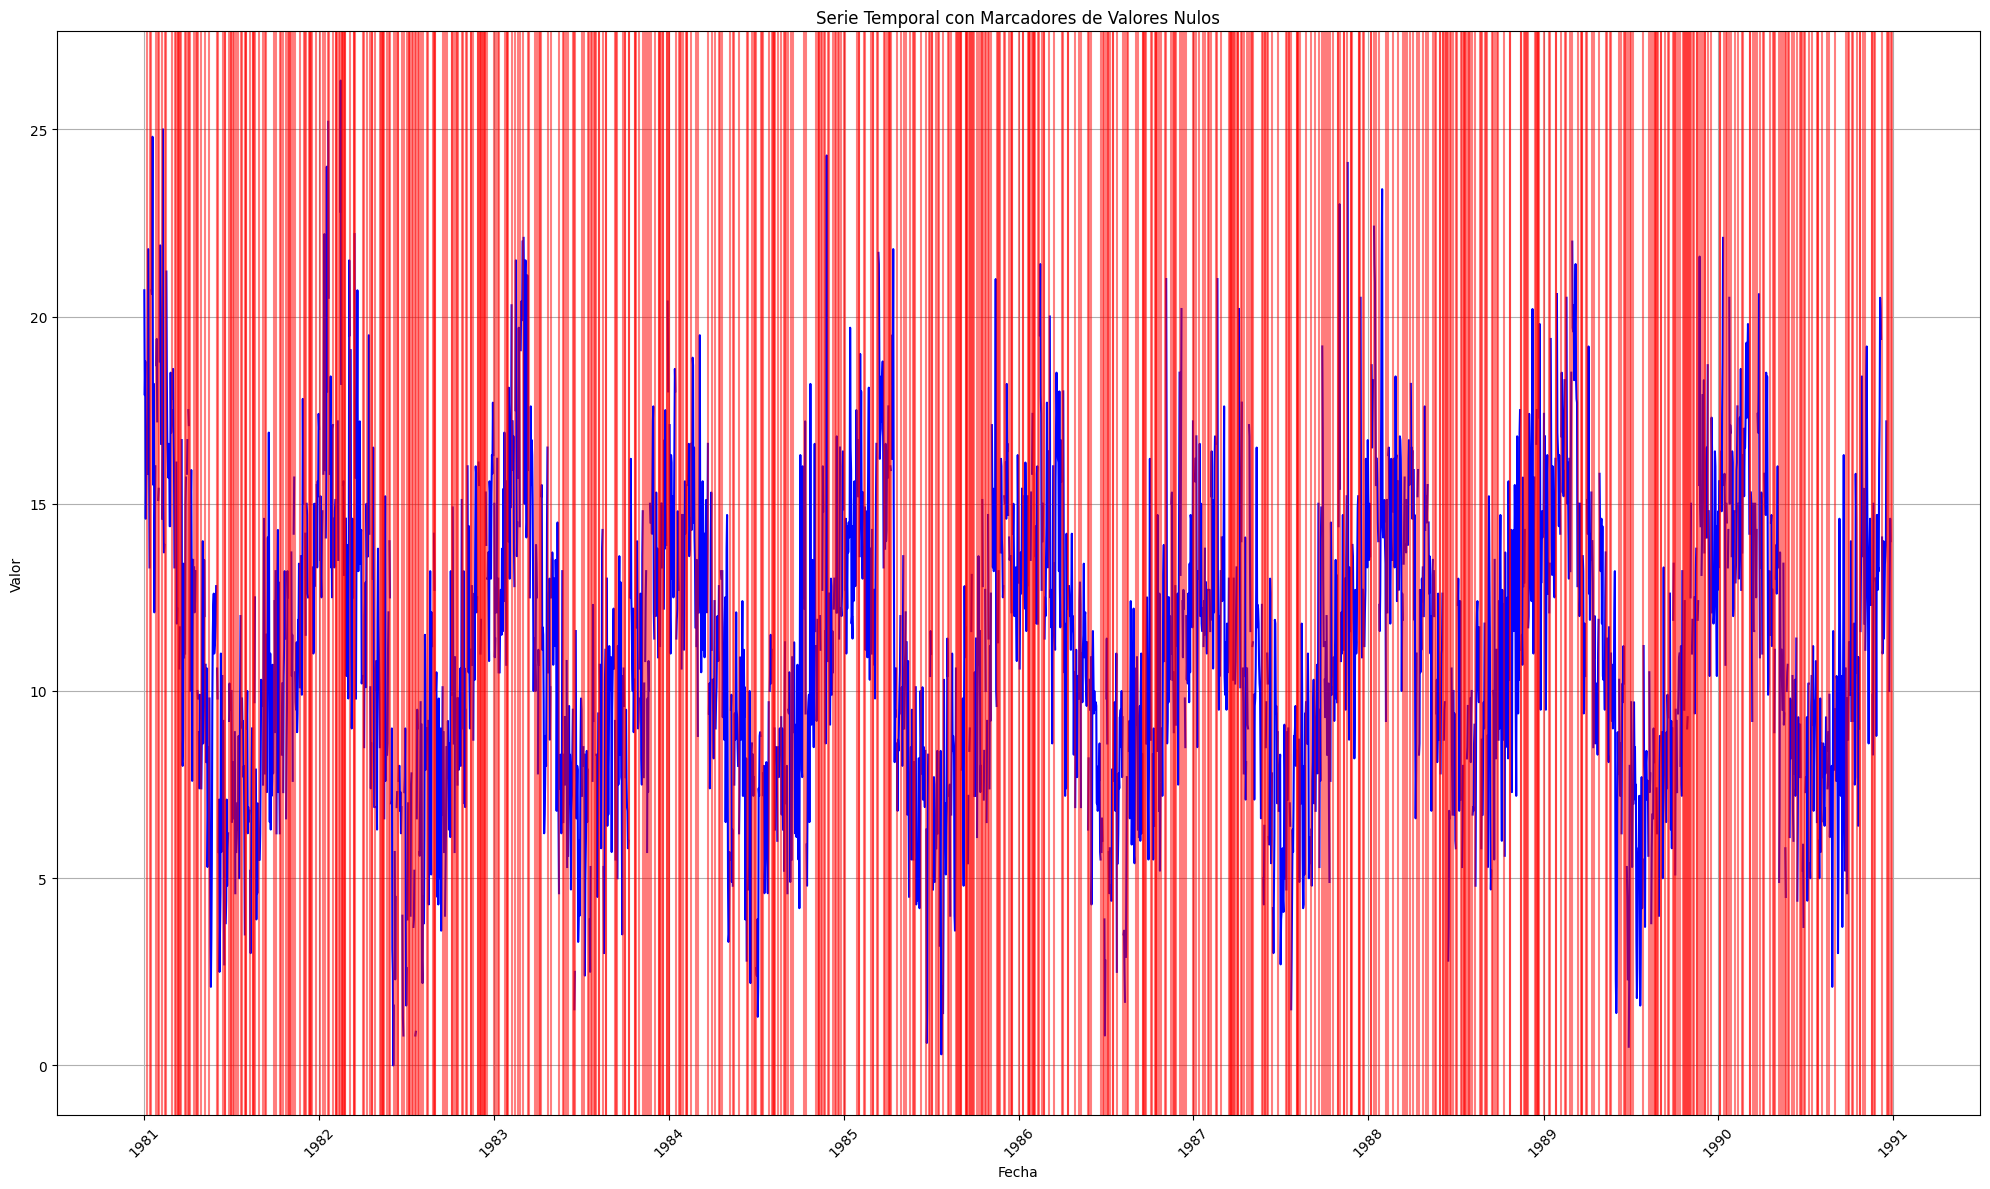

In [42]:
np.random.seed(27) # para tener resultados repetibles

serie_nulos_aleatorios = series.copy()

n_eliminar = int(len(series) * porcentaje)

indices_a_eliminar = np.random.choice(series.index, size=n_eliminar, replace=False)

serie_nulos_aleatorios.loc[indices_a_eliminar] = np.nan

dibuja_datos(serie_nulos_aleatorios)

In [43]:
serie_nulos_aleatorios[serie_nulos_aleatorios.isna()]

Date
1981-01-06   NaN
1981-01-13   NaN
1981-01-15   NaN
1981-01-25   NaN
1981-01-29   NaN
              ..
1990-12-19   NaN
1990-12-21   NaN
1990-12-23   NaN
1990-12-28   NaN
1990-12-30   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 730, dtype: float64

## Simulación fallo por batería

La intencion es eliminar tramos de unos 20 dias seguidos. Para ello, hacemos que los numeros a eliminar se dividan entre 20 (o lo que es lo mismo, multiplicar por 0.05), lo que nos da los indices desde los cuales tenemos que eliminar. Dese cada índice eliminamos los siguientes 20 dias.

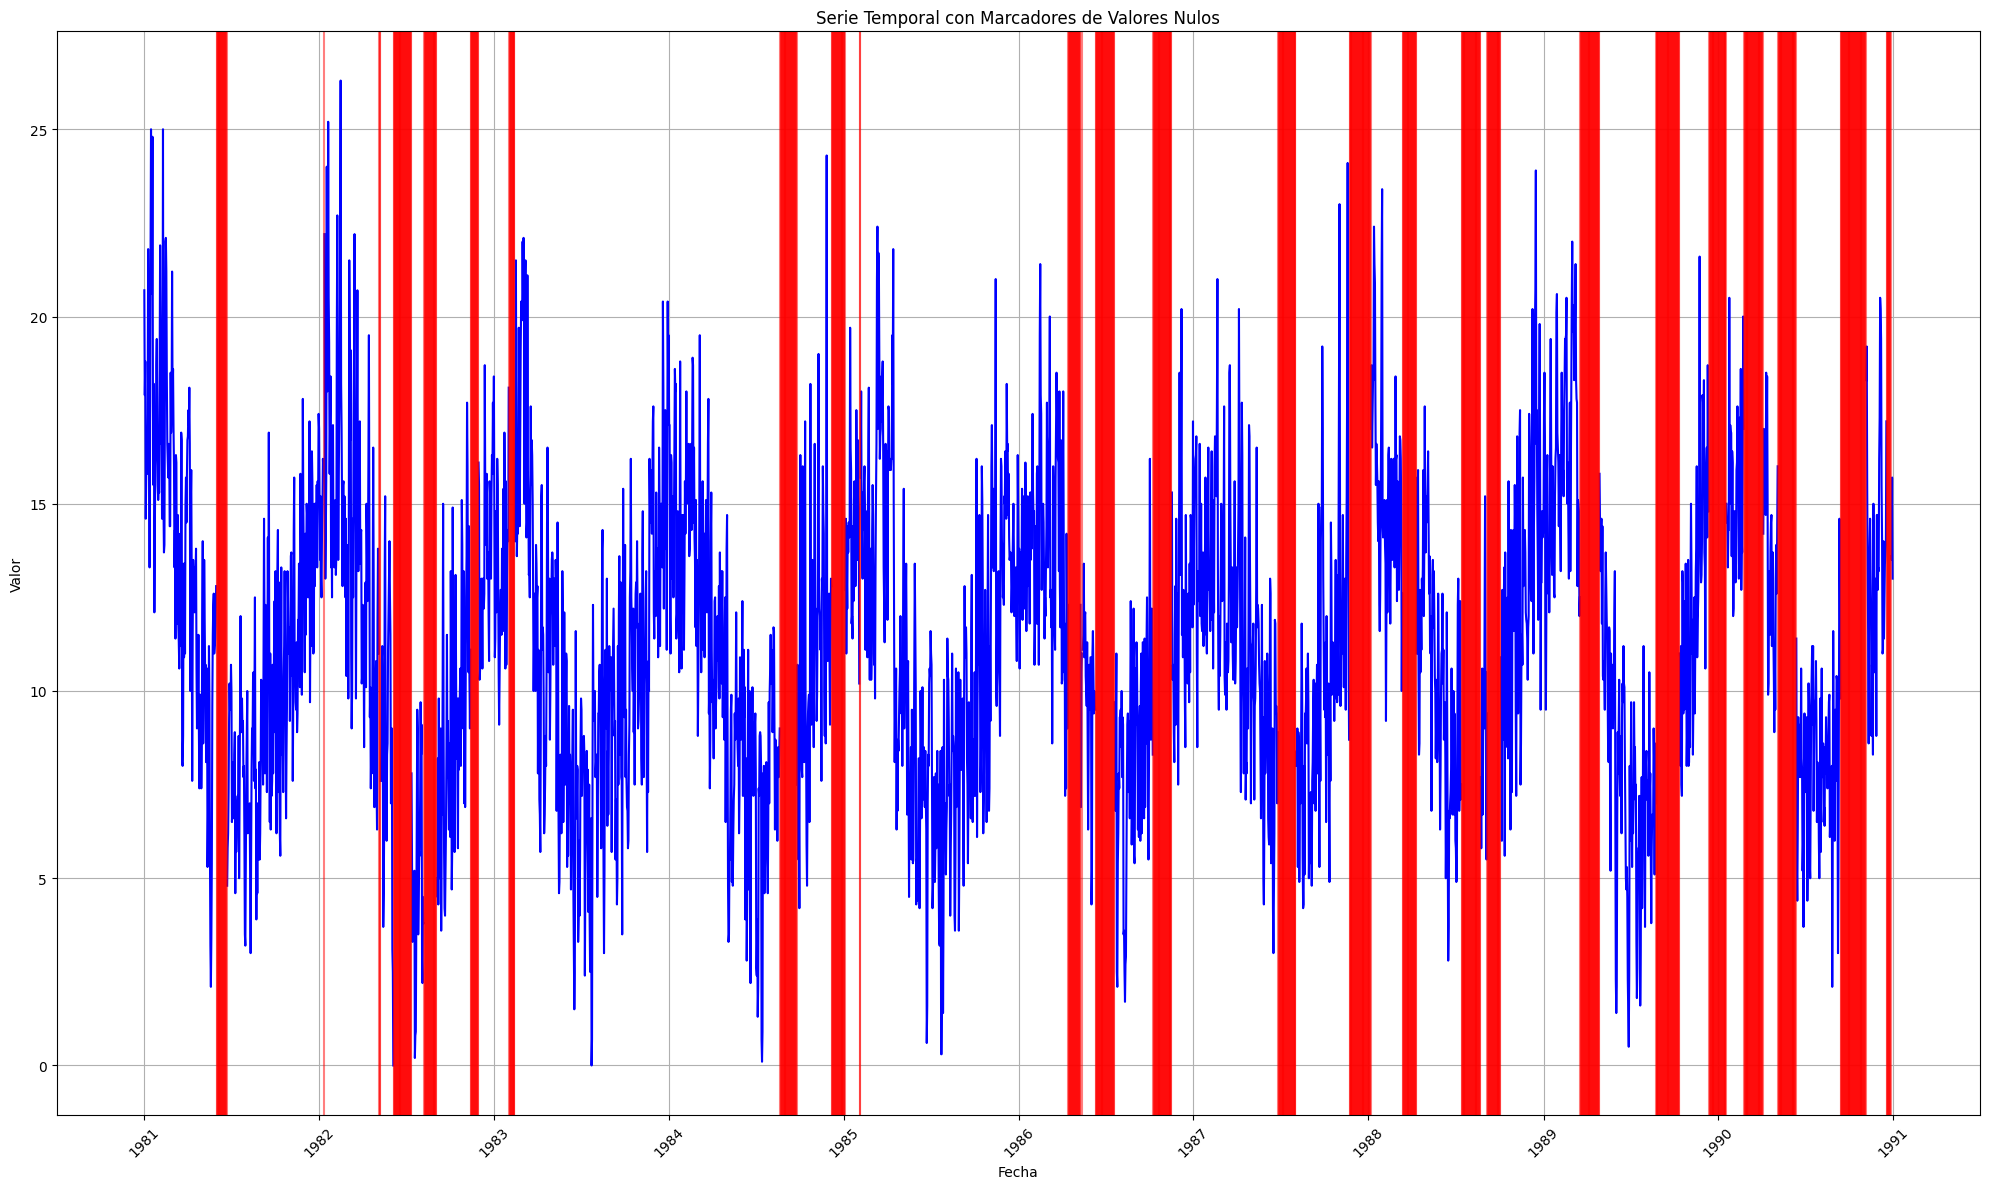

In [44]:
np.random.seed(27) # para tener resultados repetibles
random.seed(27) # para tener resultados repetibles
min = 20
max = 40

serie_nulos_seguidos = series.copy()

n_eliminar = int(len(series) * porcentaje)
n_eliminar_inicio = int(n_eliminar*0.25)
serie_nulos_seguidos_inicio = serie_nulos_seguidos.iloc[0:int(len(serie_nulos_seguidos)/2)]
serie_nulos_seguidos_final = serie_nulos_seguidos.iloc[int(len(serie_nulos_seguidos)/2):len(serie_nulos_seguidos)]

serie_nulos_seguidos = eliminar_consecutivos(serie_nulos_seguidos, serie_nulos_seguidos_inicio.index, n_eliminar_inicio, min, max)
serie_nulos_seguidos = eliminar_consecutivos(serie_nulos_seguidos, serie_nulos_seguidos_final.index, n_eliminar, min, max)
dibuja_datos(serie_nulos_seguidos)


In [45]:
serie_nulos_seguidos[serie_nulos_seguidos.isna()]

Date
1981-06-01   NaN
1981-06-02   NaN
1981-06-03   NaN
1981-06-04   NaN
1981-06-05   NaN
              ..
1990-12-23   NaN
1990-12-24   NaN
1990-12-25   NaN
1990-12-26   NaN
1990-12-27   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 730, dtype: float64

## Simulación fallo por interferencias

### Fallos pequeños distribuidos por todo el dataset

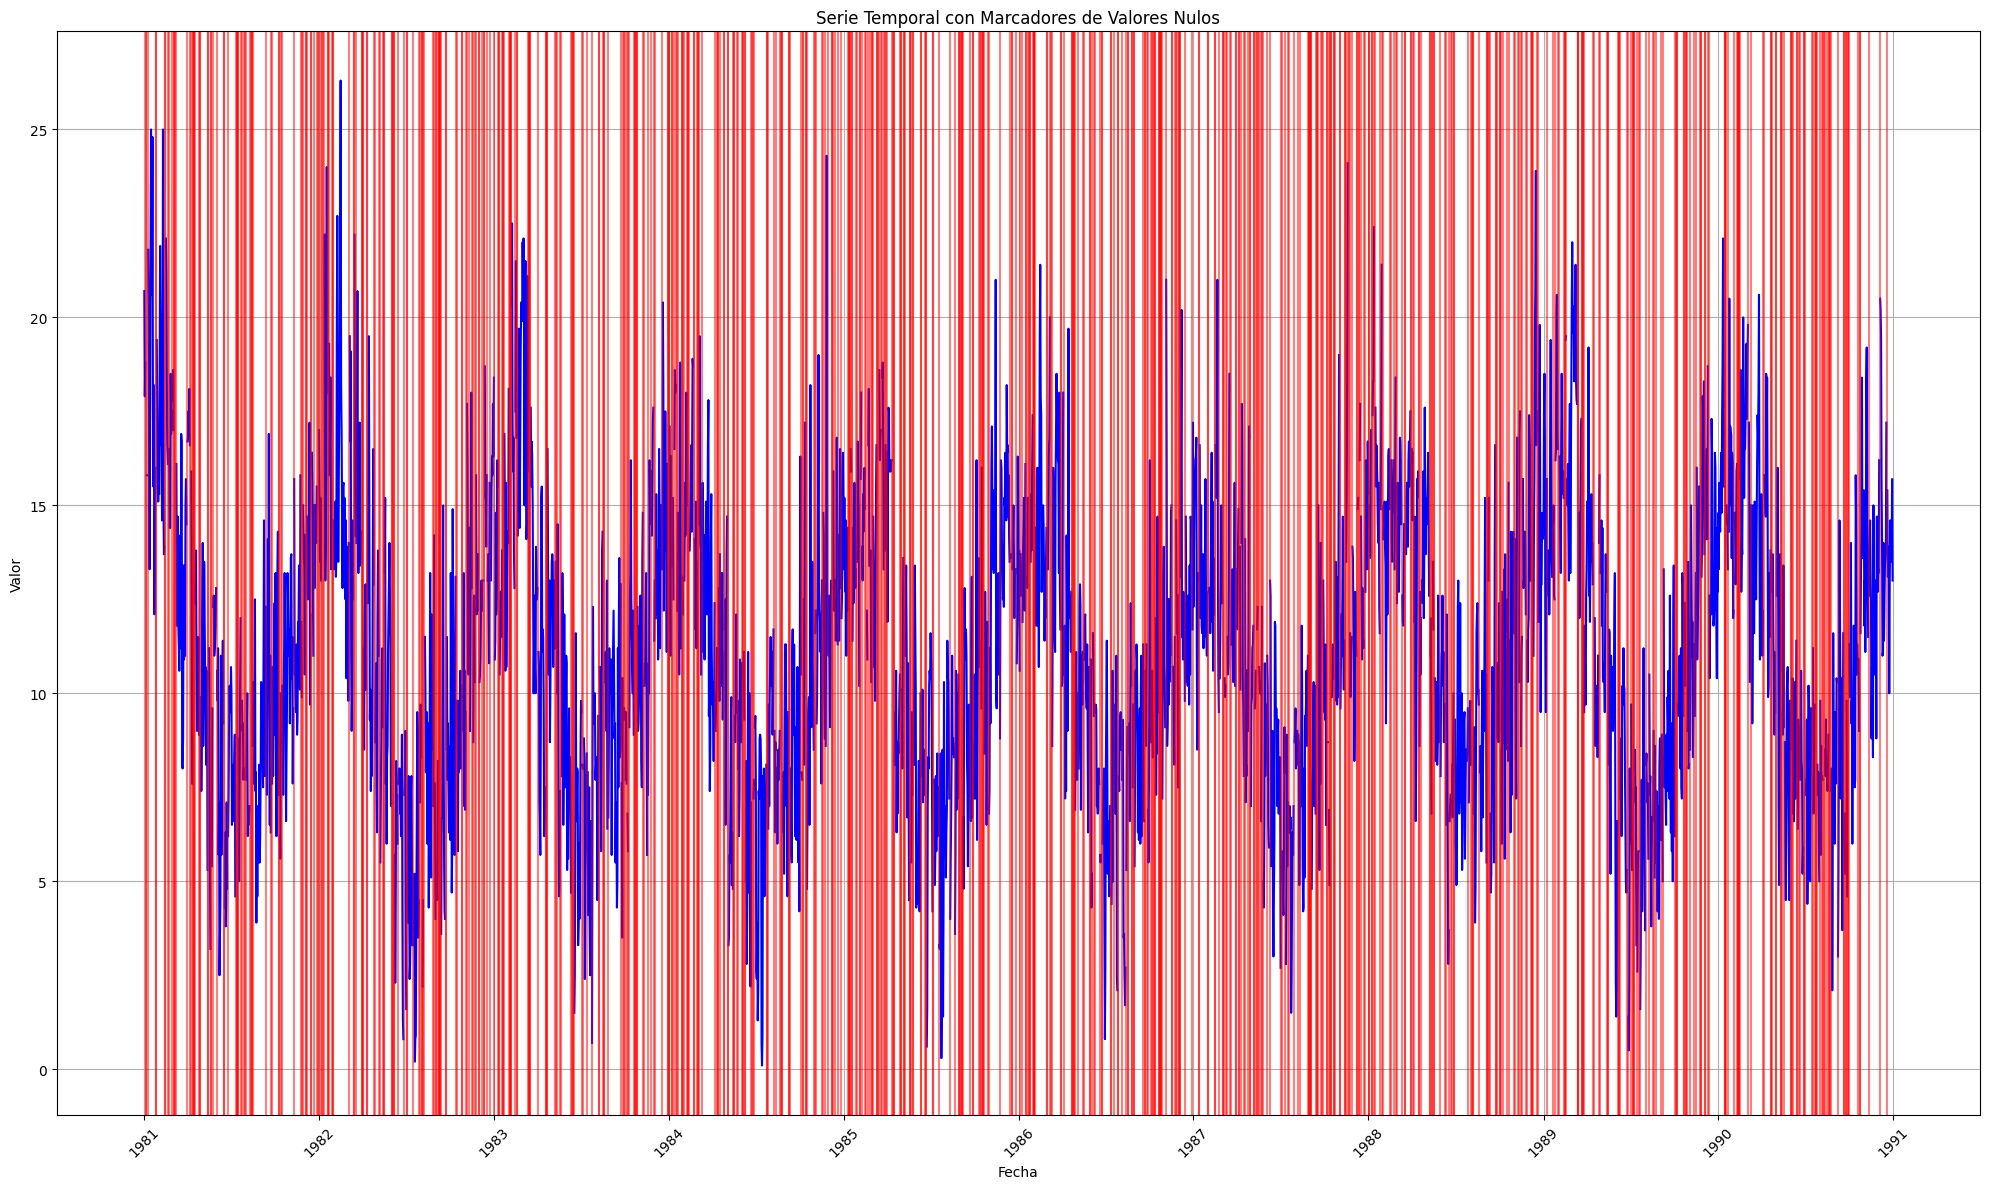

In [46]:
random.seed(27) # para tener resultados repetibles
min = 1
max = 2

serie_nulos_interferencias = series.copy()

n_eliminar = int(len(series) * porcentaje)
n_eliminar_inicio = int(n_eliminar*0.5)
serie_nulos_interferencias_inicio = serie_nulos_interferencias.iloc[0:int(len(serie_nulos_interferencias)/2)]
serie_nulos_interferencias_final = serie_nulos_interferencias.iloc[int(len(serie_nulos_interferencias)/2):len(serie_nulos_interferencias)]

serie_nulos_interferencias = eliminar_consecutivos(serie_nulos_interferencias, serie_nulos_interferencias_inicio.index, n_eliminar_inicio, min, max)
serie_nulos_interferencias = eliminar_consecutivos(serie_nulos_interferencias, serie_nulos_interferencias_final.index, n_eliminar, min, max)

dibuja_datos(serie_nulos_interferencias)

In [47]:
serie_nulos_seguidos[serie_nulos_seguidos.isna()]

Date
1981-06-01   NaN
1981-06-02   NaN
1981-06-03   NaN
1981-06-04   NaN
1981-06-05   NaN
              ..
1990-12-23   NaN
1990-12-24   NaN
1990-12-25   NaN
1990-12-26   NaN
1990-12-27   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 730, dtype: float64

### Fallos pequeños pero en secciones concretas más grandes (pendiente de revisión)

Parecido al anterior pero esta vez se cogen periodos de 60 dias y se elimina uno de cada 3

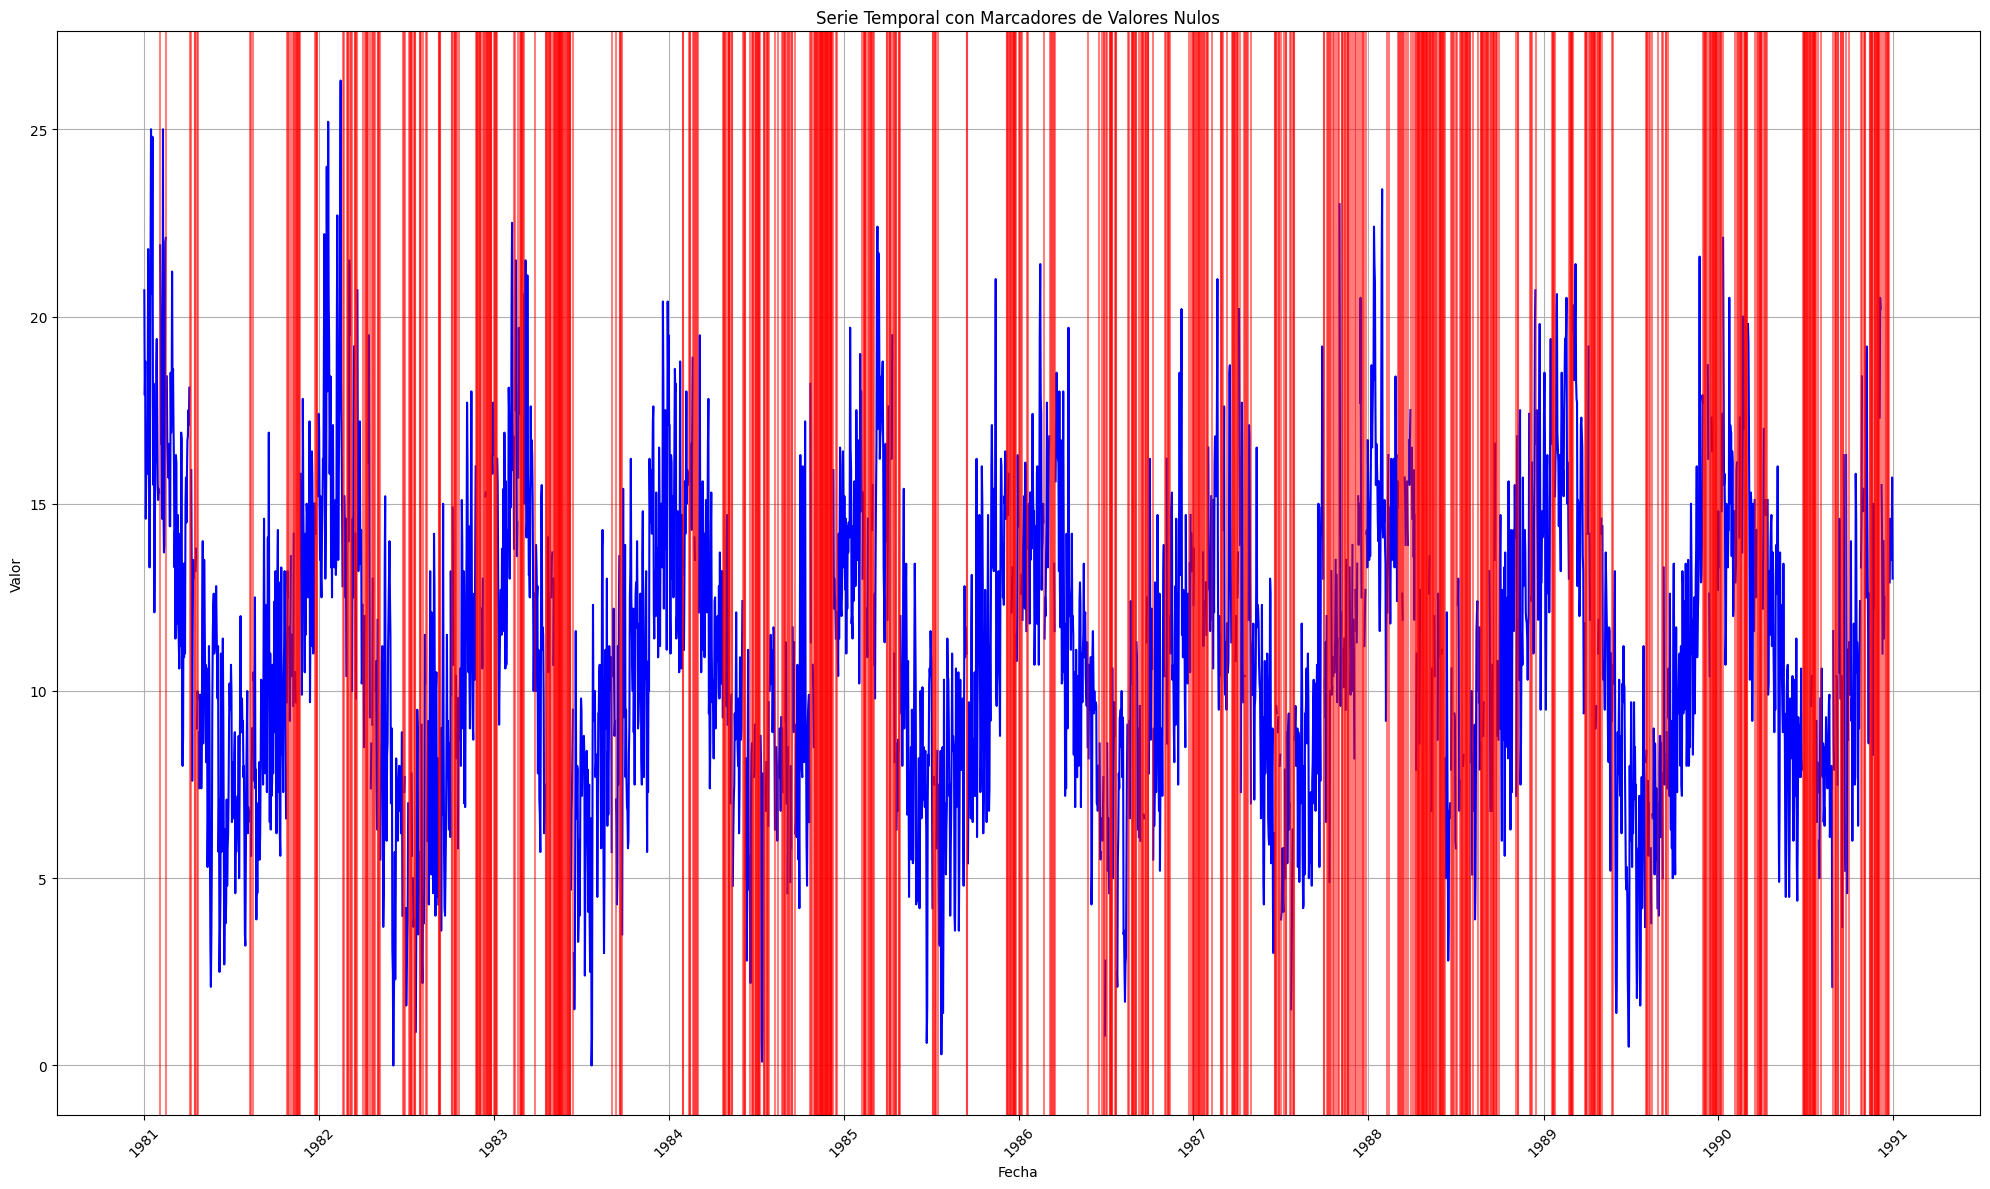

In [48]:
random.seed(27) # para tener resultados repetibles
min = 1
max = 48

serie_nulos_interferencias_zona = series.copy()

n_eliminar = int(len(series) * porcentaje)

serie_nulos_interferencias = eliminar_zona(serie_nulos_interferencias_zona, serie_nulos_interferencias_zona.index, n_eliminar, min, max)

dibuja_datos(serie_nulos_interferencias_zona)

Se ve que se elimina uno de cada 3. Y que la cantidad de eliminados ronda el porcentaje deseado

In [49]:
serie_nulos_interferencias_zona[serie_nulos_interferencias_zona.isna()]

Date
1981-02-02   NaN
1981-02-16   NaN
1981-04-06   NaN
1981-04-08   NaN
1981-04-16   NaN
              ..
1990-12-17   NaN
1990-12-19   NaN
1990-12-21   NaN
1990-12-22   NaN
1990-12-24   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 730, dtype: float64

Aqui se ve un mes concreto

In [50]:
#serie_nulos_discontinuos['1982-10'].plot(figsize=(20,12))
#plt.show()

## Simulación fallo por error de medida

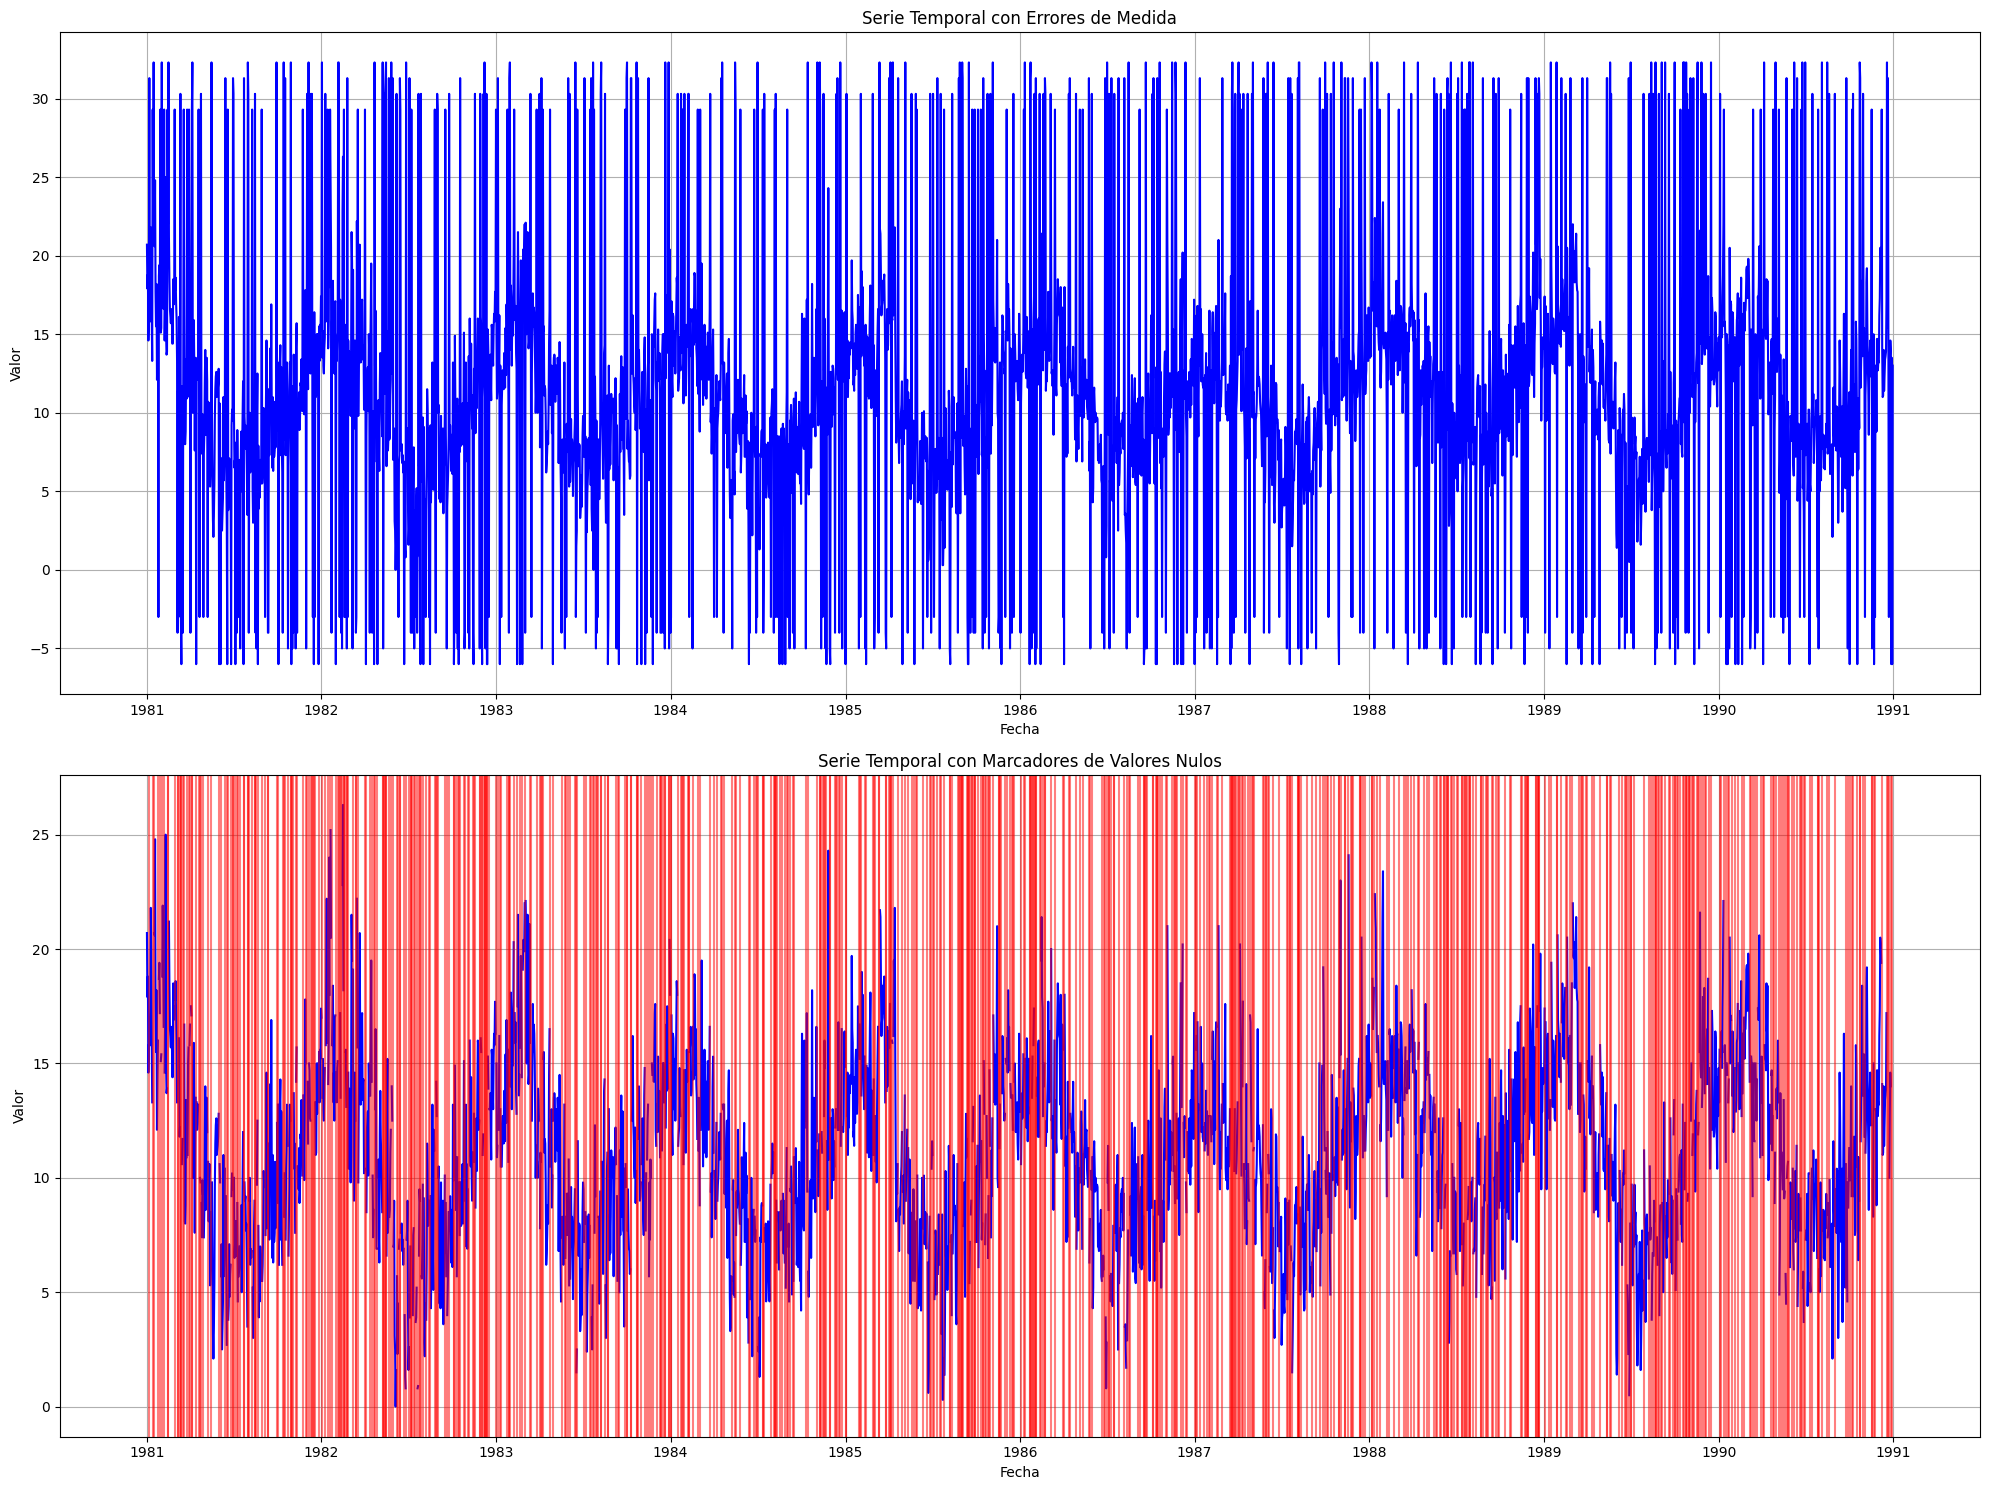

In [51]:
np.random.seed(27) # para tener resultados repetibles
random.seed(27)

serie_error_medida = series.copy()
maximo = serie_error_medida.max()
minimo = serie_error_medida.min()

n_eliminar = int(len(series) * porcentaje)

indices_con_errores = np.random.choice(series.index, size=n_eliminar, replace=False)

# Genero los errores de medida
for i in indices_con_errores:
    seleccion = random.choice([minimo, maximo])
    if seleccion > minimo:
        serie_error_medida.loc[i] =  maximo + random.randint(3,6)
    else:
        serie_error_medida.loc[i] = minimo - random.randint(3,6)

# Los elimino
serie_nulos_error_medida = serie_error_medida.copy()
serie_nulos_error_medida.loc[indices_con_errores] = np.nan

# Crear la figura y los ejes
fig, ax = plt.subplots(2,1, figsize=(20, 15))

# Dibujar la serie temporal
ax[0].plot(serie_error_medida.index, serie_error_medida.values, color='blue')
ax[1].plot(serie_nulos_error_medida.index, serie_nulos_error_medida.values, color='blue')

# Dibujar líneas verticales rojas para los valores nulos
null_dates = serie_nulos_error_medida[serie_nulos_error_medida.isna()].index
for date in null_dates:
    ax[1].axvline(x=date, color='red', linestyle='-', alpha=0.5)

# Configurar el gráfico
ax[1].set_title('Serie Temporal con Marcadores de Valores Nulos')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Valor')
ax[1].grid(True)
#ax[1].set_yticks(range(25000,250000))
# Configurar el gráfico
ax[0].set_title('Serie Temporal con Errores de Medida')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Valor')
ax[0].grid(True)
#ax[0].set_yticks(range(25000,250000))

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

## Todo junto

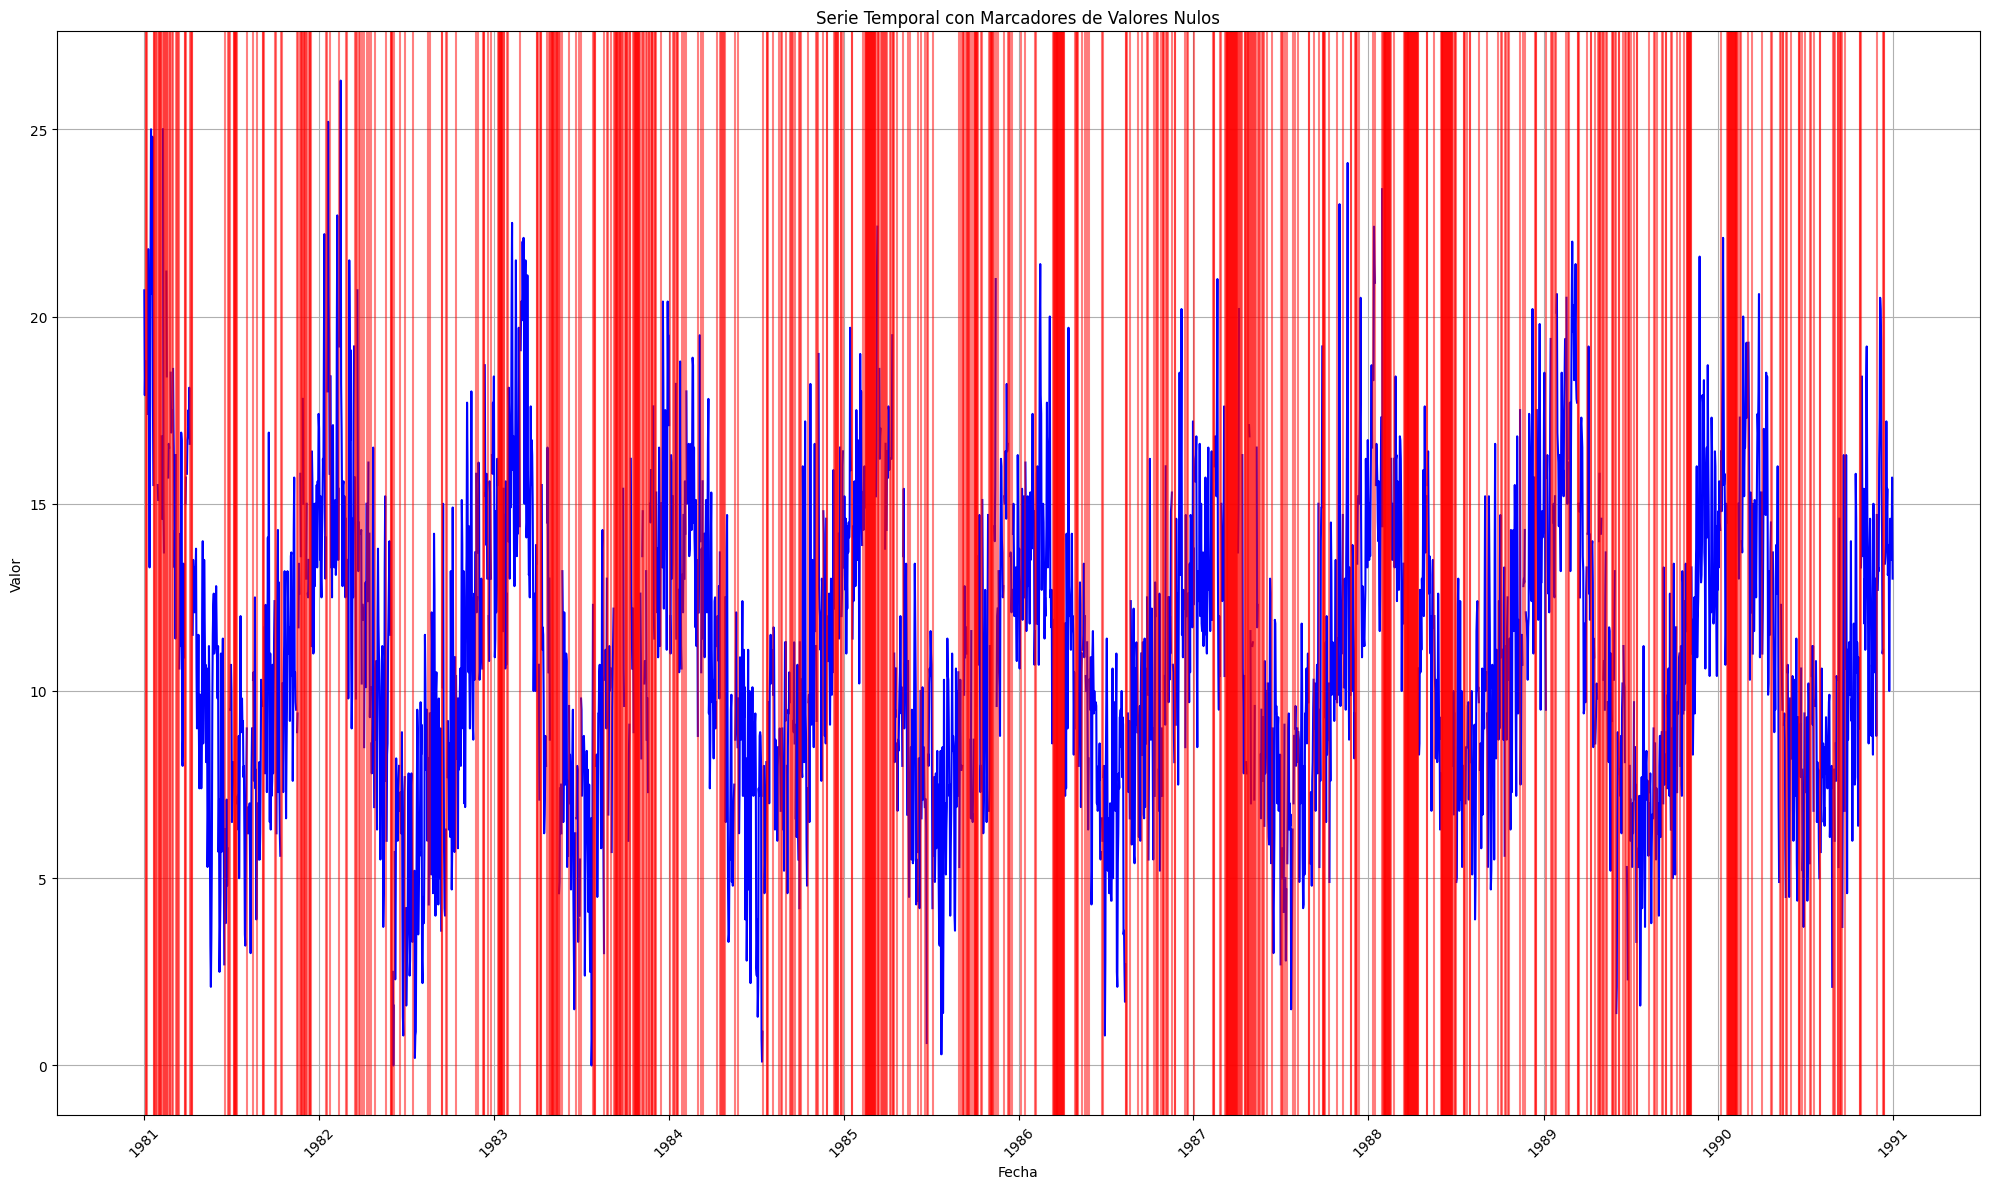

In [ ]:
serie_nulos_mix = series.copy()
serie_nulos_mix_inicio = serie_nulos_mix.iloc[0:int(len(serie_nulos_mix)/2)]
serie_nulos_mix_final = serie_nulos_mix.iloc[int(len(serie_nulos_mix)/2):len(serie_nulos_mix)]

n_eliminar = int(len(series) * porcentaje)
n_eliminar_por_seccion = int(n_eliminar/2) +1

# Seccion errores de medida
np.random.seed(3) # para tener resultados repetibles
indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar_por_seccion), replace=False)

serie_nulos_mix.loc[indices_a_eliminar] = np.nan

# Seccion interferencias
random.seed(1) # para tener resultados repetibles
min = 1
max = 2
n_eliminar_inicio_interferencias = int(n_eliminar_por_seccion*0.5)

# Como nuestra funcion se detiene al alcanzar los nulos a eliminar deseados, si simplemente ponemos "n_eliminar_inicio_interferencias" no llegaría a eliminar
# nada, ya que ya se han eliminado unas cuantas filas en la seccion anterior, por lo que debemos acarrear la suma en cada sección
suma_a_eliminar = n_eliminar_por_seccion + n_eliminar_inicio_interferencias
serie_nulos_mix = eliminar_consecutivos(serie_nulos_mix, serie_nulos_mix_inicio.index, suma_a_eliminar, min, max)
suma_a_eliminar = 2*n_eliminar_por_seccion
serie_nulos_mix = eliminar_consecutivos(serie_nulos_mix, serie_nulos_mix_final.index, suma_a_eliminar, min, max)

# Seccion batería
random.seed(2) # para tener resultados repetibles
min = 5
max = 30
n_eliminar_inicio_bateria = int(n_eliminar_por_seccion*0.25)

suma_a_eliminar = 2*n_eliminar_por_seccion + n_eliminar_inicio_bateria
serie_nulos_mix = eliminar_consecutivos(serie_nulos_mix, serie_nulos_mix_inicio.index, suma_a_eliminar, min, max)
suma_a_eliminar = 3*n_eliminar_por_seccion
serie_nulos_mix = eliminar_consecutivos(serie_nulos_mix, serie_nulos_mix_final.index, suma_a_eliminar, min, max)

# Seccion interferencias cardiovascular
random.seed(3)
min=1
max=48
suma_a_eliminar = 4*n_eliminar_por_seccion
serie_nulos_mix = eliminar_zona(serie_nulos_mix, serie_nulos_mix.index, suma_a_eliminar, min, max)

dibuja_datos(serie_nulos_mix)

In [53]:
serie_nulos_mix[serie_nulos_mix.isna()]

Date
1981-01-04   NaN
1981-01-05   NaN
1981-01-07   NaN
1981-01-21   NaN
1981-01-22   NaN
              ..
1990-10-25   NaN
1990-11-29   NaN
1990-12-12   NaN
1990-12-13   NaN
1990-12-14   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 732, dtype: float64

## Guardar datasets

Guardamos los fallos por bateria

In [54]:
#serie_nulos_seguidos.to_csv("..\miss_valued_data_cardiovascular\cardiovascular_bateria_suciedad_humedad"+str(int(porcentaje*100))+".csv")

Guardamos los fallos por interferencias

In [55]:
#serie_nulos_interferencias.to_csv("..\miss_valued_data_cardiovascular\cardiovascular_colocacion"+str(int(porcentaje*100))+".csv")

Guardamos los fallos por error en la medición

In [56]:
#serie_nulos_error_medida.to_csv("..\miss_valued_data_cardiovascular\cardiovascular_arritmias"+str(int(porcentaje*100))+".csv")

Guardamos el mix

In [57]:
#serie_nulos_mix.to_csv("..\miss_valued_data_cardiovascular\cardiovascular_mix_"+str(int(porcentaje*100))+".csv")

Guardamos interferencias por zonas

In [58]:
#serie_nulos_interferencias_zona.to_csv("..\miss_valued_data_cardiovascular\cardiovascular_interferencias"+str(int(porcentaje*100))+".csv")